In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np

In [3]:

# Define a class for applying random style deformations to images
class RandomStyleDeformation:
    def __init__(self, deformation_list):
        self.deformation_list = deformation_list

    def __call__(self, image):
        # Randomly select a style deformation function from the list
        deformation_func = random.choice(self.deformation_list)
        
        # Apply the selected deformation to the image
        return deformation_func(image)

# Define a random rotation style deformation function
def style_deformation_1(image):
    # Apply a random color jitter transformation
    color_jitter = transforms.ColorJitter(
        brightness=random.uniform(0.8, 1.2),
        contrast=random.uniform(0.8, 1.2),
        saturation=random.uniform(0.8, 1.2),
        hue=random.uniform(0.1, 0.2)
    )
    image = color_jitter(image)
    return image

# List of style deformation functions
deformation_list = [style_deformation_1]

# Create a RandomStyleDeformation object
random_style_deformation = RandomStyleDeformation(deformation_list)

In [4]:

# Define a custom dataset for your test images
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        return image

# Path to your test images
image_paths = ['data/1674921468776855 (2).jpeg', 'data/16805902646928945 (2).jpeg', 'data/1687724324700842 (2).jpeg']

# Define the height and width for resizing
height, width = 1536, 1536

# Define image transformations
image_transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
])

# Create a DataLoader for your test images
test_dataset = TestImageDataset(image_paths, transform=image_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

efficientNet_transform = models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

In [5]:

# Define the MatrixProductModel
class MatrixProductModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MatrixProductModel, self).__init__()
        
        self.R = nn.Parameter(torch.randn(input_dim, output_dim), requires_grad=True)
        self.Q = nn.Parameter(torch.randn(output_dim, input_dim), requires_grad=True)

    def forward(self, x, T):
        # Perform matrix-vector multiplication Q^T * T * R * x
        y =  torch.matmul(torch.matmul(torch.matmul(x, self.R), T), self.Q)
        return y

# Define the NeuralPreset model with nn.ModuleList that containes efficientnet_b0, model_n, model_s
class NeuralPreset(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralPreset, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim

        self.model_n =  MatrixProductModel(input_dim, output_dim)
        self.model_s =  MatrixProductModel(input_dim, output_dim)
        # self.efficientnet_b0 = models.EfficientNetB0(pretrained=True) in case if you want to download the custom model
        self.efficientnet_b0 = torch.load('efficientnet_b0.pth').eval()
        
        # Replace the final classifier with a new fully connected layer which ouputs 2*output_dim*output_dim tensor
        in_features = self.efficientnet_b0.classifier.in_features
        self.efficientnet_b0.classifier = nn.Linear(in_features, 2 * output_dim * output_dim)  # 2 stands for two vectors, r and d
        # Freeze the first layer
        for i, layer in enumerate(self.efficientnet_b0.children()):
            if i < 2:
                for param in layer.parameters():
                    param.requires_grad = False

    def forward(self, x1, x2):
        # Get T from the encoder
        downsampled_x1 = efficientNet_transform(x1)
        downsampled_x2 = efficientNet_transform(x2)

        # Output features = 256, so k is fixed to 16
        # d_i, r_i - normalized color space, color style
        d_1, r_1 = self.efficientnet_b0(downsampled_x1).chunk(2, dim=1)
        d_2, r_2 = self.efficientnet_b0(downsampled_x2).chunk(2, dim=1)

        # Perform operations using model_n and model_s
        k = self.output_dim
        Z_1 = self.model_n(x1.reshape(-1, 3), d_1.reshape(k, k))
        Z_2 = self.model_n(x2.reshape(-1, 3), d_2.reshape(k, k))

        Y_1 = self.model_s(Z_2, r_1.reshape(k, k))
        Y_2 = self.model_s(Z_1, r_2.reshape(k, k))
        

        return Z_1, Z_2, Y_1, Y_2
    
    def modeln(self, image, d):
        '''Color-normalizes the image based on the content vector d.

        Args:
            image (_type_): _description_
            d (_type_): _description_

        Returns:
            _type_: _description_
        '''        
        k = self.output_dim
        Z = self.model_n(image.reshape(-1, 3), d.reshape(k, k))
        return Z
    
    def models(self, image, r):
        '''Stylizes the image based on the style vector r.

        Args:
            image (_type_): _description_
            r (_type_): _description_

        Returns:
            _type_: _description_
        '''        
        k = self.output_dim
        Y = self.model_s(image.reshape(-1, 3), r.reshape(k, k))
        return Y
    def encoder(self, image):
        '''Downsamples the image and returns the content vector d and style vector r.
        Args:
            image (_type_): _description_
        Returns:
            _type_: _description_
        '''        
        downsampled = efficientNet_transform(image)
        d, r = self.efficientnet_b0(downsampled).chunk(2, dim=1)
        return d, r
    
# Custom loss function that combines L1 norms and L2 norm
def custom_loss(Z_1, Z_2, Y_1, Y_2, I_1, I_2, coef_l):
    # Calculate L2 norm
    l2_norm = F.mse_loss(Z_1, Z_2)

    # Calculate L1 norms
    l1_norm1 = F.l1_loss(Y_1, I_1)
    l1_norm2 = F.l1_loss(Y_2, I_2)

    # Combine the L1 norms as needed
    loss = coef_l * l2_norm + l1_norm1 + l1_norm2
    
    return loss


In [6]:
# Set the number of classes in your task (adjust as needed)
k = 16

# Lambda coefficient
coef_l = 10

# Initialize the model and optimizer with Adam
model = NeuralPreset(3,k)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 150


In [7]:
for epoch in tqdm(range(num_epochs)):
    model.train() 
    for image in test_dataloader:

        # Get random style transformations
        x1 = random_style_deformation(image)
        x2 = random_style_deformation(image)

        Z_1, Z_2, Y_1, Y_2 = model(x1,x2)

        optimizer.zero_grad()

        # Calculate loss, coef lambda = 10
        loss = custom_loss(Z_1, Z_2, Y_1, Y_2, x1.reshape(-1, 3), x2.reshape(-1, 3), coef_l)
        loss.backward()

        optimizer.step()
        
        # Print the loss value at each step
        print("Epoch {}: Loss = {:.4f}".format(epoch, loss.item()))


  0%|          | 0/150 [00:00<?, ?it/s]

c:\Users\dimav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0: Loss = 26.4566
Epoch 0: Loss = 6705.6841
Epoch 0: Loss = 187.5476
Epoch 1: Loss = 347.9516
Epoch 1: Loss = 552.4806
Epoch 1: Loss = 1604.4810
Epoch 2: Loss = 364.4049
Epoch 2: Loss = 739.6895
Epoch 2: Loss = 3113.3787
Epoch 3: Loss = 5.3856
Epoch 3: Loss = 948.0482
Epoch 3: Loss = 46.3281
Epoch 4: Loss = 159.3991
Epoch 4: Loss = 715.4272
Epoch 4: Loss = 1642.1611
Epoch 5: Loss = 101.5340
Epoch 5: Loss = 29.6924
Epoch 5: Loss = 210.1138
Epoch 6: Loss = 70.9224
Epoch 6: Loss = 62.7441
Epoch 6: Loss = 244.1510
Epoch 7: Loss = 28.1273
Epoch 7: Loss = 137.9219
Epoch 7: Loss = 28.4185
Epoch 8: Loss = 7.6820
Epoch 8: Loss = 26.1400
Epoch 8: Loss = 96.9342
Epoch 9: Loss = 56.4102
Epoch 9: Loss = 16.1717
Epoch 9: Loss = 361.4943
Epoch 10: Loss = 195.7428
Epoch 10: Loss = 98.9570
Epoch 10: Loss = 110.8372
Epoch 11: Loss = 83.0322
Epoch 11: Loss = 286.0274
Epoch 11: Loss = 607.8049
Epoch 12: Loss = 20.5343
Epoch 12: Loss = 303.7306
Epoch 12: Loss = 67.2044
Epoch 13: Loss = 99.4312
Epoch 

# Usage examples

In [16]:
def plot_image_3d(image, subplot, dots=10_000):
    """Plots the 3D scatter plot of the image."""
    # Convert image into numpy array
    img_array = np.array(image) / 255
    r, g, b = img_array[:, :, 0].flatten(), img_array[:, :, 1].flatten(), img_array[:, :, 2].flatten()
    idxes = np.random.randint(0, len(r), dots)
    colors = img_array.reshape(-1, 3)

    # Plotting
    subplot.scatter(r[idxes], g[idxes], b[idxes], c=colors[idxes], alpha=0.5, s=1)

In [8]:
# Evaluate the trained model on an image
model.eval()
image_c = Image.open('data/1687724324700842 (2).jpeg')

# Transform the image for inference
image_transformed = image_transform(image_c).unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    # Perform necessary transformations using the model
    d, r = model.encoder(image_transformed)
    Z = model.modeln(image_transformed, d)
    Y = model.models(Z, r)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


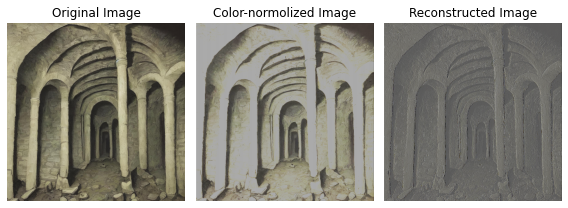

In [9]:
# Display the original image and the transformed image
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_c)
plt.axis('off')

# Transformed Image
plt.subplot(1, 3, 2)
plt.title('Color-normolized Image')
plt.imshow(Z.view(3, height, width).permute(1, 2, 0).numpy())
plt.axis('off')

# Transformed Image
plt.subplot(1, 3, 3)
plt.title('Reconstructed Image')
plt.imshow(Y.view(3, height, width).permute(1, 2, 0).numpy())
plt.axis('off')

plt.tight_layout()
plt.show()

In [52]:
def reconstruct_image(model, image_path, image_transform, height, width):
    # Load the image
    image = Image.open(image_path)

    # Transform the image for inference
    image_transformed = image_transform(image).unsqueeze(0)  # Add a batch dimension

    # Perform inference
    with torch.no_grad():
        # Get content and style vectors for the image
        d, r = model.encoder(image_transformed)
        Z = model.modeln(image_transformed, d)
        Y_reconstructed = model.models(Z, r)

    # Clip values to [0, 1] range for displaying images
    Y_reconstructed = torch.clamp(Y_reconstructed, 0, 1)

    # Plot the 3D color distribution
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(122, projection='3d')
    plot_image_3d(Y_reconstructed.view(3, height, width).permute(1, 2, 0).numpy(), ax1)
    ax1.set_title('Reconstructed Image')
    
    ax2 = fig.add_subplot(121, projection='3d')
    plot_image_3d(image, ax2)
    ax2.set_title('Original Image')
    plt.show()

    # Display the original and reconstructed images
    plt.figure(figsize=(8, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(Y_reconstructed.view(3, height, width).permute(1, 2, 0).numpy())
    plt.axis('off')

    plt.tight_layout()
    plt.show()


c:\Users\dimav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


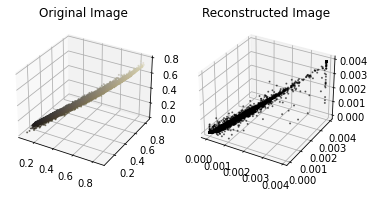

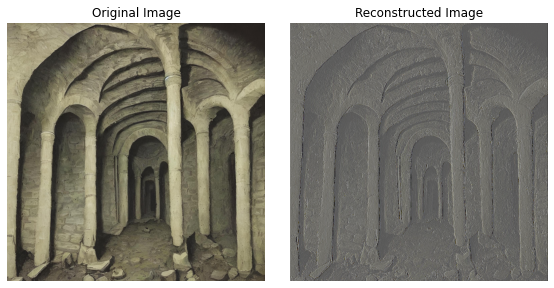

In [53]:
# Assuming you have 'model', 'image_transform', 'height', and 'width' defined previously
image_path = 'data/1687724324700842 (2).jpeg'
reconstruct_image(model, image_path, image_transform, height, width)

In [45]:
def perform_style_transfer(model, content_image_path, style_image_path, image_transform, height, width):
    # Load content and style images
    content_image = Image.open(content_image_path)
    style_image = Image.open(style_image_path)

    # Transform the images for inference
    content_transformed = image_transform(content_image).unsqueeze(0)  # Add a batch dimension for content
    style_transformed = image_transform(style_image).unsqueeze(0)  # Add a batch dimension for style

    # Perform inference
    with torch.no_grad():
        # Get content and style vectors for the respective images
        d_content, r_content = model.encoder(content_transformed)
        d_style, r_style = model.encoder(style_transformed)

        # Apply style transfer
        Z_content = model.modeln(content_transformed, d_content)
        Y_style_transferred = model.models(Z_content, r_style)

    # Clipping the values to [0, 1] range
    Y_style_transferred = torch.clamp(Y_style_transferred, 0, 1).view(3, height, width).permute(1, 2, 0).numpy()

    # Create a figure with subplots for all visualizations
    fig = plt.figure(figsize=(30, 15))
    images = [content_image, style_image, Y_style_transferred]
    
    titles = ['Content Image', 'Style Image', 'Style-Transferred Image']

    for i in range(3):
        # Display the images
        ax = fig.add_subplot(2, 3, i + 1)
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')

    for i in range(3):
        # Plot 3D color distributions
        ax = fig.add_subplot(2, 3, i + 4, projection='3d')
        plot_image_3d(images[i], ax)
        ax.set_title(titles[i])
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')
        ax.view_init(elev=30, azim=347)

    plt.tight_layout()
    plt.show()


c:\Users\dimav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(1536, 1536, 3)


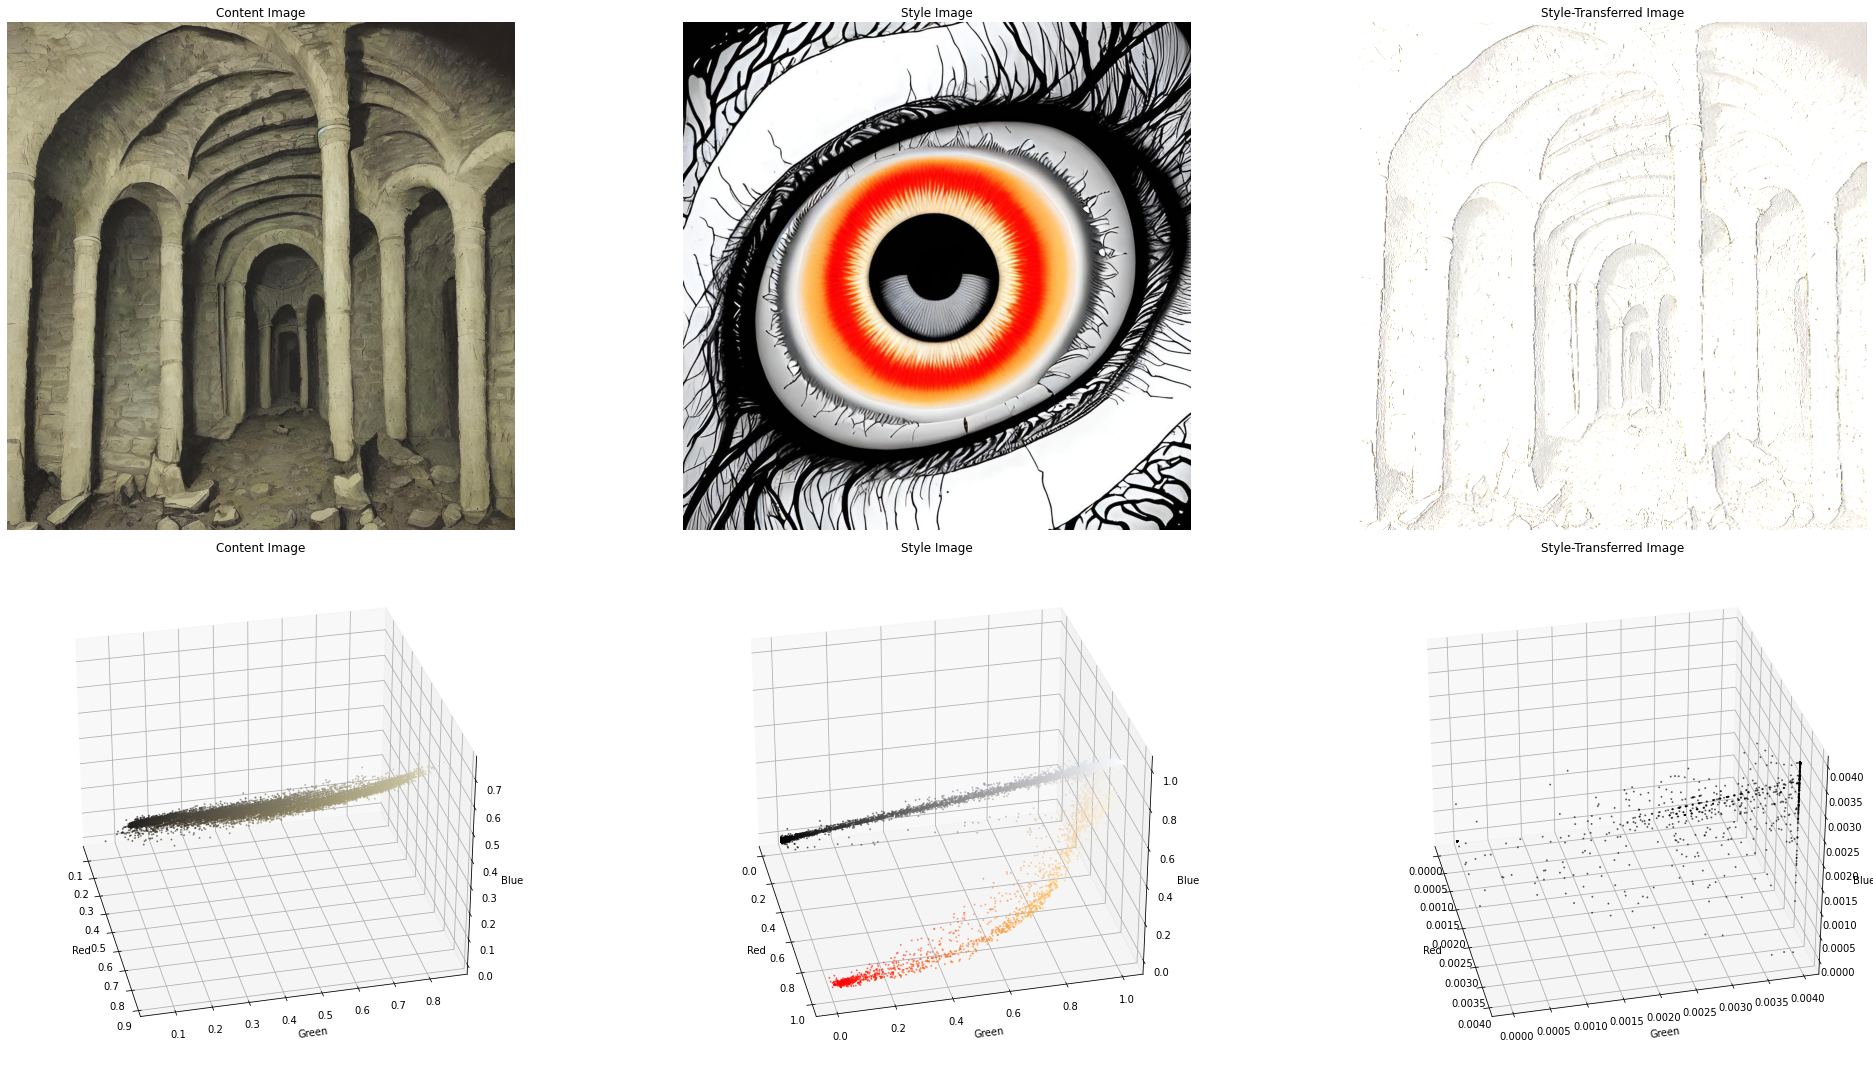

In [46]:
# Assuming you have 'model', 'image_transform', 'height', and 'width' defined previously
content_path = 'data/1687724324700842 (2).jpeg'
style_path = 'data/16805902646928945 (2).jpeg'
perform_style_transfer(model, content_path, style_path, image_transform, height, width)

(1536, 1536, 3)


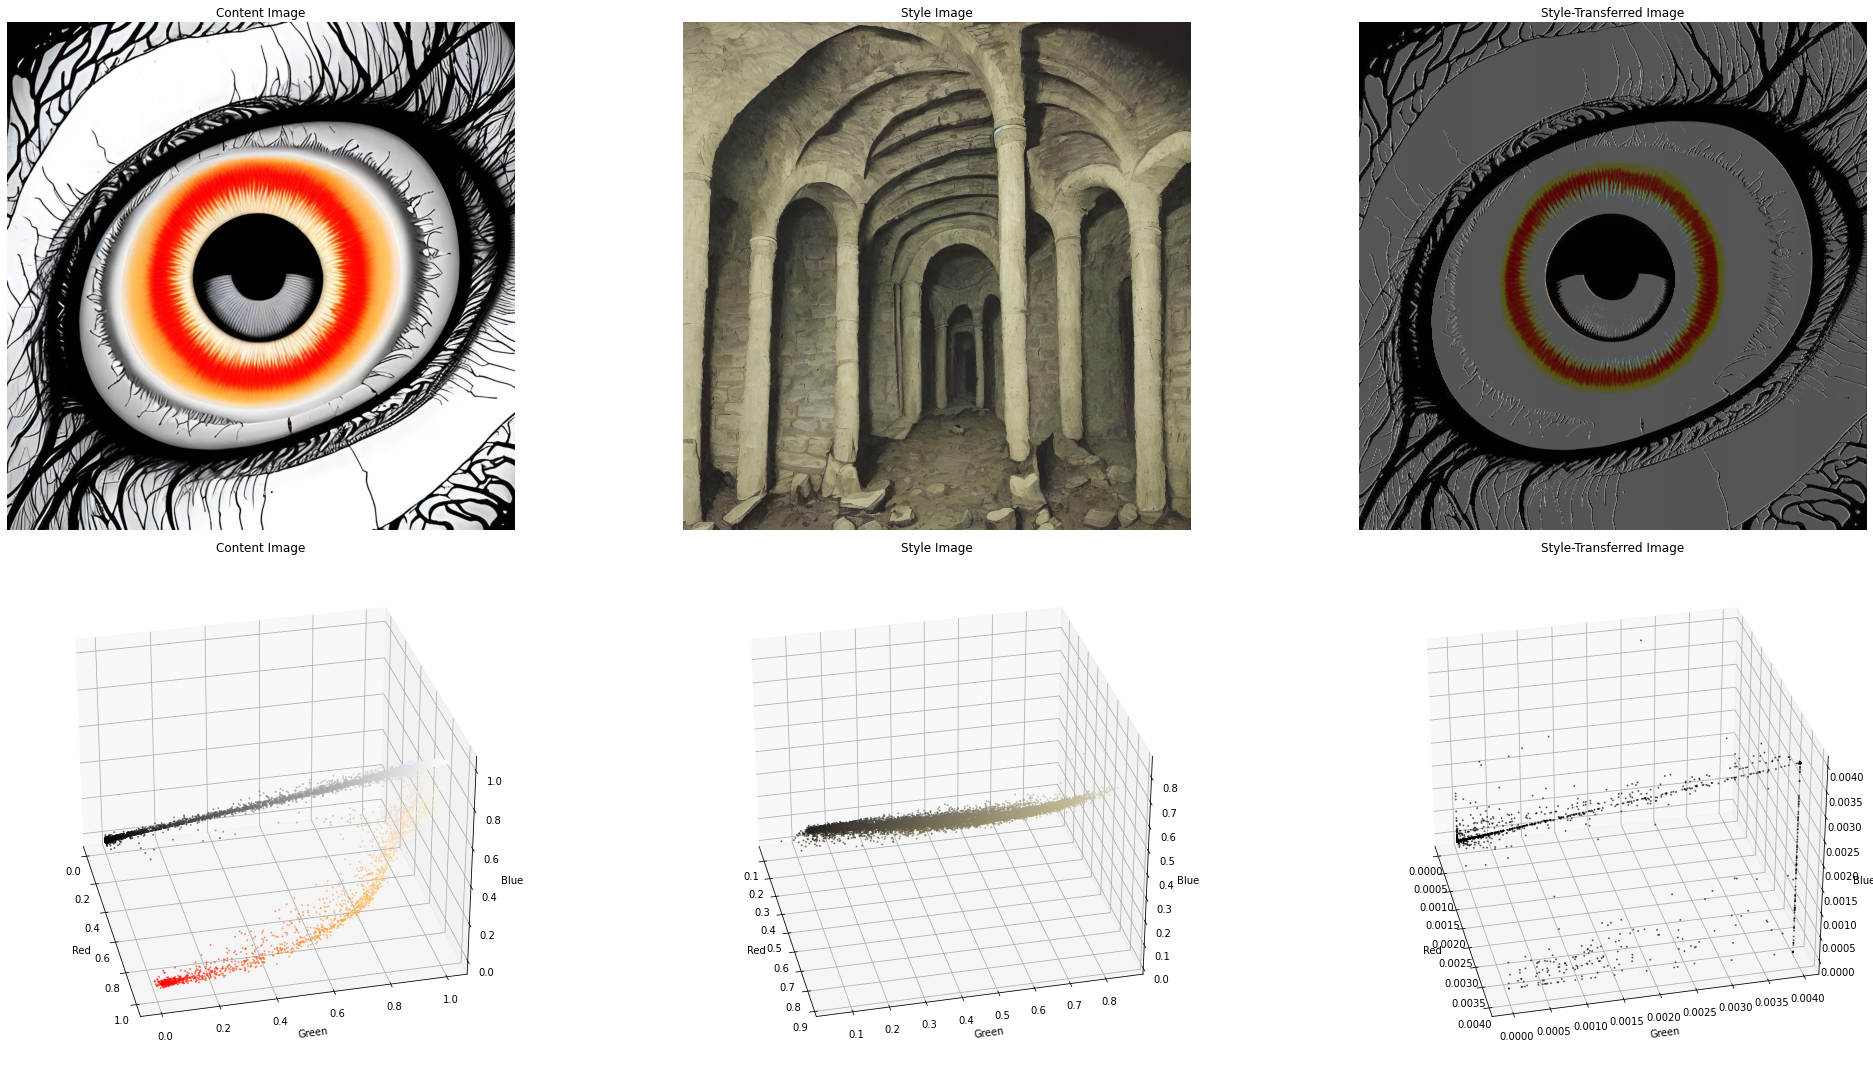

In [47]:
perform_style_transfer(model, style_path, content_path, image_transform, height, width)